# Installations and Dependencies

In [9]:
%%capture
!pip3 --no-cache-dir install torch torchvision torchaudio

In [93]:
%%capture
!pip install stable-baselines3[extra]

In [13]:
%%capture
!pip install gymnasium

In [151]:
%%capture
!pip install pytesseract

In [8]:
%%capture
!pip install pyautogui

In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import time
import torch as th
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker
import pyautogui
pyautogui.FAILSAFE = False
import cv2
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'D:\Tesseract-OCR\tesseract.exe'

# Enviroment

In [2]:
class GameEnviroment(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(150, 150, 1), dtype=np.uint8)
        self.action_space = Discrete(3)
        self.game_location = (0, 100, 350, 450) #x1, y1, width, height
        self.game_over_location = (150, 275, 660, 70)
        self.score_location = (850, 250, 100, 40)
        self.previous_score = 0

    def step(self, action):
        #Action Keys => 0 = Idle, 1 = Jump, 2 = Down
        
        if action == 1:
            pyautogui.press('space')
        elif action == 2:
            pyautogui.keyDown('down')
            time.sleep(0.3)
            pyautogui.keyUp('down')

        observation = self.get_observation().numpy()
        terminated = self.isGameOver()

        current_score = self.get_score()

        reward = current_score - self.previous_score

        if terminated:
            reward -= 20

        self.previous_score = current_score
            
        info = {}
        
        return observation, reward, terminated, False, info

    def get_observation(self):
        raw = np.array(pyautogui.screenshot(region=self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized_gray = cv2.resize(gray, (150, 150))
        channels = np.expand_dims(resized_gray, axis=-1)
        channels = th.tensor(channels, dtype=th.uint8)
        
        return channels

    def isGameOver(self):
        game_over_print = np.array(pyautogui.screenshot(region=self.game_over_location))[:, :, :3].astype(np.uint8)
        gray = cv2.cvtColor(game_over_print, cv2.COLOR_BGR2GRAY)
        _, threshold = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

        game_over_text = pytesseract.image_to_string(threshold)[:4]
        game_over = game_over_text == "GAME"
        
        return game_over

    def reset(self, seed=None):
        time.sleep(1)
        pyautogui.click(x=150, y=250)
        info = {}
        return self.get_observation().numpy(), info

    def get_score(self):
        raw = np.array(pyautogui.screenshot(region=self.score_location))[:, :, :3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        _, threshold = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

        score_text = pytesseract.image_to_string(threshold)[:-1]
        if len(score_text) != 5:
            score_text = score_text[:5]

        try:
            return int(score_text)
        except ValueError:
            return self.previous_score + 1
        

In [30]:
env = GameEnviroment()

In [5]:
env.action_space.sample()

0

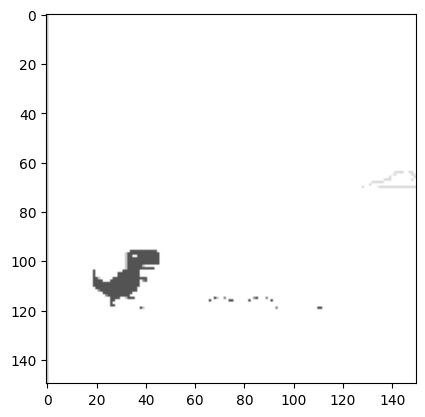

In [9]:
obs = env.get_observation()
teste = cv2.cvtColor(obs.numpy(), cv2.COLOR_BGR2RGB)
plt.imshow(teste)

In [10]:
gameover = env.isGameOver()
gameover

False

In [11]:
score = env.get_score()
score
#plt.imshow(score)

9

# Test the enviroment

In [87]:
for episode in range(2):
    obs = env.reset()
    terminated = False
    total_ep_reward = 0

    while not terminated:
        obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
        total_ep_reward += reward

    print(f"Episode: {episode}, Reward: {total_ep_reward}")

Episode: 0, Reward: -92
Episode: 1, Reward: -87


# Train the model

In [12]:
env_checker.check_env(env)

In [22]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)   

        return True

In [23]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [24]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [3]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from stable_baselines3.common.vec_env import VecNormalize

In [10]:
env = GameEnviroment()

In [27]:
model = DQN('MlpPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=50000, learning_starts=500)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [32]:
model.learn(total_timesteps=20000, callback=callback)

Logging to ./logs/DQN_5
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 7.25     |
|    ep_rew_mean      | -15.5    |
|    exploration_rate | 0.986    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 27       |
|    total_timesteps  | 29       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 7.5      |
|    ep_rew_mean      | -16.5    |
|    exploration_rate | 0.972    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 55       |
|    total_timesteps  | 60       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 7.67     |
|    ep_rew_mean      | -18.5    |
|    exploration_rate | 0.956    |
| time/               |        

In [33]:
model.save("dqn_model")

# Evaluate the model

In [7]:
model = DQN.load('train/best_model_48000')

In [8]:
num_ep = 100
acc_reward = []

In [11]:
for episode in range(num_ep):
    obs, _ = env.reset()
    terminated = False
    total_ep_reward = 0

    while not terminated:
        #obs_np = obs.detach().cpu().numpy()
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        total_ep_reward += reward

    acc_reward.append(total_ep_reward)
    print(f"Episode: {episode}, Reward: {total_ep_reward}")

Episode: 0, Reward: 28
Episode: 1, Reward: -26
Episode: 2, Reward: -20
Episode: 3, Reward: -20
Episode: 4, Reward: 3
Episode: 5, Reward: -43
Episode: 6, Reward: -10
Episode: 7, Reward: -15
Episode: 8, Reward: -35
Episode: 9, Reward: -11
Episode: 10, Reward: -29
Episode: 11, Reward: -13
Episode: 12, Reward: -11
Episode: 13, Reward: -36
Episode: 14, Reward: -20
Episode: 15, Reward: -6
Episode: 16, Reward: -34
Episode: 17, Reward: -11
Episode: 18, Reward: -13
Episode: 19, Reward: -36
Episode: 20, Reward: -20
Episode: 21, Reward: -10
Episode: 22, Reward: -30
Episode: 23, Reward: -20
Episode: 24, Reward: -20
Episode: 25, Reward: -20
Episode: 26, Reward: -7
Episode: 27, Reward: -33
Episode: 28, Reward: -20
Episode: 29, Reward: -20
Episode: 30, Reward: -20
Episode: 31, Reward: -20
Episode: 32, Reward: -20
Episode: 33, Reward: -20
Episode: 34, Reward: -20
Episode: 35, Reward: -5
Episode: 36, Reward: -20
Episode: 37, Reward: -25
Episode: 38, Reward: -30
Episode: 39, Reward: -11
Episode: 40, Rew

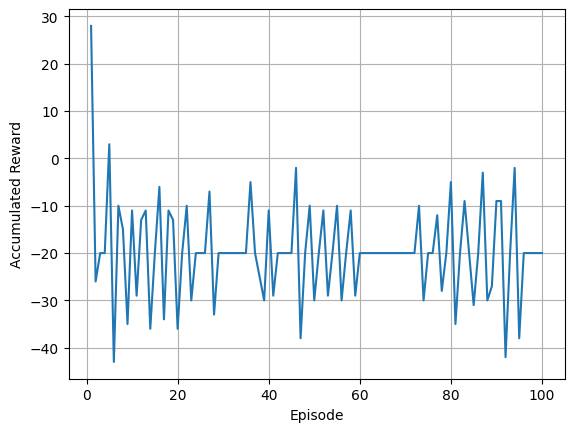

In [12]:
episodes = np.arange(1, num_ep + 1)
plt.plot(episodes, acc_reward)
plt.xlabel('Episode')
plt.ylabel('Accumulated Reward')
plt.grid(True)
plt.show()